In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

yf.pdr_override()

y_symbol_pairs = [('^RUT', 'USD'), ('^MXX', 'MXN'), ('000001.SS', 'CNY'), ('^N225', 'JPY'),('^JKSE', 'IDR'), ('^N100', 'EUR'), ('^KLSE', 'MYR')]
index_symbol = 'XWD.TO' # msci world

start_date = dt.datetime(2000,1,1)
end_date = dt.datetime(2020,1,2)
start_date_plus_10 = start_date.replace(year = start_date.year + 9, month=12)


In [2]:
def convert_to_USD(index_data, currency):
    if currency == 'USD':
        return index_data
    # get historical conversion rate to USD
    tckr = yf.Ticker(currency+"USD=X")
    df = tckr.history(start=start_date, end=end_date)
    # fixing stupid error in the data
    if currency=="IDR":
        df.loc["2010-11-01"]=df.loc["2010-11-02"]
    currency_data = df.resample('BMS').first()
    
    # convert the data
    for item in index_data.items():
        closest_date = currency_data.index[currency_data.index.get_loc(item[0], method='nearest')]
        #print(item[0])
        #print("closest date: " + str(closest_date))
        #print("before: " + str(item[1]))
        exchange_rate = currency_data.loc[closest_date]["Open"]
        #print("exchange_rate: " + str(exchange_rate))
        index_data[item[0]] = item[1]*exchange_rate
        #print("after: " + str(index_data[item[0]]))
        #print("________________________________")
    
    return index_data

In [3]:
data = pdr.get_data_yahoo([symbol for symbol, _ in y_symbol_pairs], start=start_date, end=end_date, interval='1mo')['Adj Close']
data_broad_market = pdr.get_data_yahoo(index_symbol, start=start_date_plus_10, end=end_date, interval='1mo')['Adj Close']


for symbol, currency in y_symbol_pairs:
    data[symbol] = convert_to_USD(data[symbol], currency)


[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
data

,000001.SS,^JKSE,^KLSE,^MXX,^N100,^N225,^RUT
Date,,,,,,,
2000-01-01,185.460025,0.055622,243.490893,589.184603,1118.991969,191.434298,496.230011
2000-02-01,207.157206,0.050393,259.371541,659.224671,1212.207232,186.206922,577.710022
2000-03-01,217.505168,0.050981,257.296024,668.591637,1228.934425,184.767160,539.090027
2000-04-01,221.866335,0.046039,237.219437,594.106075,1254.675133,174.130005,506.250000
2000-05-01,228.902099,0.039710,240.694493,533.311269,1265.072512,151.058541,476.179993
...,...,...,...,...,...,...,...
2019-09-01,405.990955,0.435118,376.852256,2140.460400,1208.091630,204.946029,1523.369995
2019-10-01,410.324440,0.437938,381.652750,2196.205403,1196.610370,212.173464,1562.449951
2019-11-01,408.056034,0.425586,374.069449,2226.101606,1260.606611,215.650404,1624.500000


In [5]:
# 10 years sliding window
sliding_windows_data = {}

for j in range(11):
    i=12*j
    returns = (data / data.shift(1))[1+i:12*10+i]
    logReturn = np.log(returns)
    #var(aX) = a^2var(X), cov(aX, aX) = a^2 cov(X,X)
    #print(returns)
    yearly_mean = 12 * logReturn.mean()
    yearly_var = 12 * logReturn.var()
    yearly_std = np.sqrt(yearly_var)
    yearly_cov = 12 * logReturn.cov()
    
    dates = (data.index[i], data.index[12*10+i])

    sliding_windows_data[str(j+1) +'_yearly_mean'] = yearly_mean
    sliding_windows_data[str(j+1) +'_yearly_var'] = yearly_var
    sliding_windows_data[str(j+1) +'_yearly_std'] = yearly_std
    sliding_windows_data[str(j+1) +'_yearly_cov'] = yearly_cov
    sliding_windows_data[str(j+1) +'_dates'] = dates
    
    

In [6]:
table_yearly_returns = pd.DataFrame(columns=(list(data.columns)))
#expected yearly returns:
for j in range(11):
    dates = sliding_windows_data[str(j+1) +'_dates']
    label = f"{dates[0].year} to {dates[1].year}"
    table_yearly_returns.loc[label] = sliding_windows_data[str(j+1) +'_yearly_mean'].round(2)
table_yearly_returns

,000001.SS,^JKSE,^KLSE,^MXX,^N100,^N225,^RUT
2000 to 2010,0.10,0.13,0.04,0.15,-0.01,-0.05,0.02
2001 to 2011,0.06,0.22,0.09,0.17,-0.03,0.00,0.04
2002 to 2012,0.07,0.21,0.09,0.15,-0.02,0.04,0.04
2003 to 2013,0.08,0.21,0.12,0.19,0.04,0.06,0.08
2004 to 2014,0.06,0.14,0.10,0.14,0.03,0.05,0.07
2005 to 2015,0.13,0.14,0.08,0.10,0.01,0.03,0.07
2006 to 2016,0.13,0.10,0.05,0.04,-0.00,0.01,0.04
2007 to 2017,0.02,0.07,0.00,-0.01,-0.03,0.01,0.05
2008 to 2018,-0.02,0.05,0.00,0.00,-0.00,0.05,0.08
2009 to 2019,0.02,0.13,0.04,0.04,0.04,0.07,0.11


In [7]:
print(table_yearly_returns.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  000001.SS &  \textasciicircum JKSE &  \textasciicircum KLSE &  \textasciicircum MXX &  \textasciicircum N100 &  \textasciicircum N225 &  \textasciicircum RUT \\
\midrule
2000 to 2010 &       0.10 &   0.13 &   0.04 &  0.15 &  -0.01 &  -0.05 &  0.02 \\
2001 to 2011 &       0.06 &   0.22 &   0.09 &  0.17 &  -0.03 &   0.00 &  0.04 \\
2002 to 2012 &       0.07 &   0.21 &   0.09 &  0.15 &  -0.02 &   0.04 &  0.04 \\
2003 to 2013 &       0.08 &   0.21 &   0.12 &  0.19 &   0.04 &   0.06 &  0.08 \\
2004 to 2014 &       0.06 &   0.14 &   0.10 &  0.14 &   0.03 &   0.05 &  0.07 \\
2005 to 2015 &       0.13 &   0.14 &   0.08 &  0.10 &   0.01 &   0.03 &  0.07 \\
2006 to 2016 &       0.13 &   0.10 &   0.05 &  0.04 &  -0.00 &   0.01 &  0.04 \\
2007 to 2017 &       0.02 &   0.07 &   0.00 & -0.01 &  -0.03 &   0.01 &  0.05 \\
2008 to 2018 &      -0.02 &   0.05 &   0.00 &  0.00 &  -0.00 &   0.05 &  0.08 \\
2009 to 2019 &       0.02 &   0.13 &   0.04 &  0.04 &   0.04

In [8]:
yearly_cov_tables = []
#cov_matrices:
for j in range(11):
    table = sliding_windows_data[str(j+1) +'_yearly_cov'].round(2)
    table.name = f"{dates[0].year} to {dates[1].year}"
    yearly_cov_tables.append(table)
yearly_cov_tables[5]

,000001.SS,^JKSE,^KLSE,^MXX,^N100,^N225,^RUT
000001.SS,0.09,0.03,0.02,0.02,0.02,0.02,0.02
^JKSE,0.03,0.07,0.03,0.04,0.03,0.02,0.03
^KLSE,0.02,0.03,0.03,0.02,0.02,0.01,0.01
^MXX,0.02,0.04,0.02,0.05,0.03,0.02,0.03
^N100,0.02,0.03,0.02,0.03,0.04,0.02,0.03
^N225,0.02,0.02,0.01,0.02,0.02,0.04,0.02
^RUT,0.02,0.03,0.01,0.03,0.03,0.02,0.04


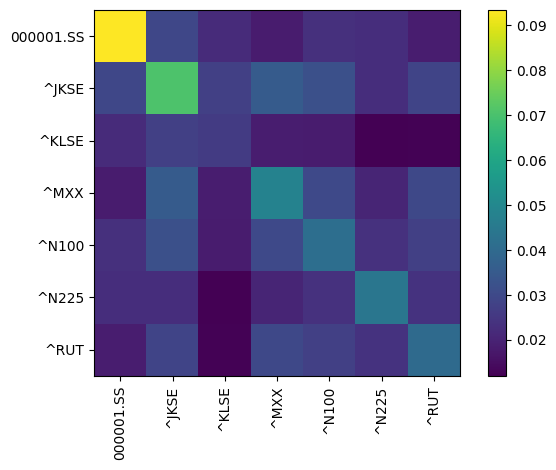

In [9]:
from pypfopt.plotting import plot_covariance
#cov_matrices:
for j in range(4,5):
    plot_covariance(sliding_windows_data[str(j+1) +'_yearly_cov'])

# Efficient frontiers & Tobin separation

In [10]:
# Don't rerun without restarting the kernel!

In [11]:
import numpy as np
import matplotlib.pyplot as plt

runs = 10000

tobin_separation = True

risk_free_rate = 0.01

# x of the portfolio value allowed to be shorted
shorting_allowed = 1
cost_of_shorting = risk_free_rate



#take a list of lists of frontier returns and variances
f_r = []
f_v = []
sharper = []
#w = [] #append weights for each portfolio
frontiers_portfolios = []
highest_sharper_portfolios = []

for j in range(11):
    returns = sliding_windows_data[str(j+1) +'_yearly_mean']
    covariances = sliding_windows_data[str(j+1) +'_yearly_cov']
    shorting = [1]*len(returns)
    if shorting_allowed:
        shorting = [-1 if a<0 else 1 for a in returns]

    frontier_mean_returns = []
    frontier_stds = []
    w = []
    for i in range(runs):
        weights = np.random.normal(0, 1, size=len(returns)) #use normal distribution
        weights = [x if x >= 0 else 0 for x in weights]  
        weights /= np.sum(weights)
        # make weights negative where shorting is necessary
        weights = weights*shorting

        # normalize (abs of all negative values should add up to a value lower than the shorting_allowed value)
        sum_of_negatives = sum([min(weight, 0) for weight in weights])
        if shorting_allowed < abs(sum_of_negatives):
            weights = np.array([weight*(shorting_allowed/abs(sum_of_negatives)) if weight < 0 else weight for weight in weights])

        # normalize (all positive values should add up to 1+(negative values))
        sum_of_positives = sum([max(weight, 0) for weight in weights])
        sum_of_negatives = sum([min(weight, 0) for weight in weights])

        #print(sum_of_negatives)
        #print(sum_of_positives)
        #print(weights)
        if 0 < sum_of_positives < 1:
            weights = np.array([weight*((1+abs(sum_of_negatives))/sum_of_positives) if weight > 0 else weight for weight in weights])
        #print(weights)
        #print(sum([max(weight, 0) for weight in weights])+sum([min(weight, 0) for weight in weights]))
        
        # make shorting cost
        returns_new = returns
        for i, (return_new, weight) in enumerate(zip(returns_new, weights)):
            # if we short a stock that goes down
            if return_new<0 and weight<0:
                returns_new[i] += cost_of_shorting
        
        if np.isnan(weights).any():
            continue
        portfolio_return = np.sum(returns_new * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariances, weights)))
        frontier_mean_returns.append(portfolio_return)
        frontier_stds.append(portfolio_std)
        w.append(weights)
    frontiers_portfolios.append(w)
    f_r.append(frontier_mean_returns)
    f_v.append(frontier_stds)

    # highest sharper portfolio
    sharper.append((np.array(frontier_mean_returns)-risk_free_rate) / np.array(frontier_stds))
    index = sharper[-1].argmax(axis=0)
    highest_sharper_portfolios.append({
        "dates": sliding_windows_data[str(j+1) +'_dates'],
        "return": frontier_mean_returns[index],
        "std": frontier_stds[index],
        "weights": frontiers_portfolios[j][index]})
    #print(highest_sharper_portfolios[-1]["return"])
    #print(sum(sliding_windows_data[str(j+1) +'_yearly_mean']*highest_sharper_portfolios[-1]["weights"]))



In [12]:
import matplotlib
cmap = matplotlib.cm.get_cmap("Set3")
cmap = [[c-0.3 for c in cmap(i+1)] for i in range(12)]
cmap[0] = [0.4, 0.4, 1, 0.7]

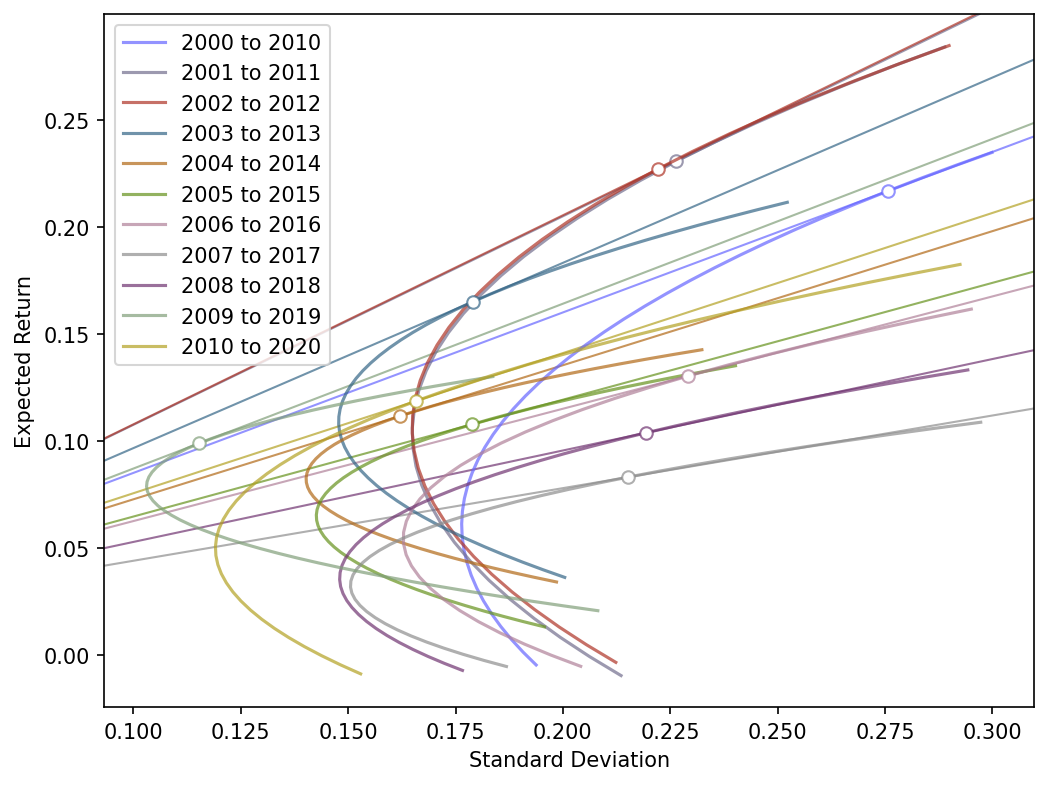

,000001.SS,^JKSE,^KLSE,^MXX,^N100,^N225,^RUT
2000 to 2010,0.44,0.00,0.00,1.41,-0.85,-0.00,0.00
2001 to 2011,0.00,0.73,0.00,1.06,-0.79,0.00,0.00
2002 to 2012,0.00,0.00,0.71,0.99,-0.70,0.00,0.00
2003 to 2013,0.00,0.21,0.29,0.50,0.00,0.00,0.00
2004 to 2014,0.00,0.10,0.50,0.40,0.00,0.00,0.00
2005 to 2015,0.23,0.31,0.21,0.25,0.00,0.00,0.00
2006 to 2016,0.68,0.61,0.00,0.00,-0.91,0.00,0.62
2007 to 2017,0.00,0.65,0.00,-0.33,-0.49,0.00,1.17
2008 to 2018,-0.22,0.00,0.00,0.00,-0.55,0.43,1.35
2009 to 2019,0.00,0.57,0.00,0.00,0.00,0.00,0.43


<Figure size 640x480 with 0 Axes>

In [13]:
from scipy.interpolate import make_interp_spline
from matplotlib.pyplot import figure
import pandas as pd

table = pd.DataFrame(columns=(list(data.columns)))

# cutoff on x-axis
cutoff = 0.3

fig = figure(figsize=(8, 6), dpi=150)
# Loop through the subplots and plot something on each of them
for i in range(11):
    # sort points by risk
    points = sorted(zip(f_v[i], f_r[i]))
    frontier_points_max = [points[0]]
    frontier_points_min = [points[0]]

    for point in points:
        if point[1]>frontier_points_max[-1][1]:
            frontier_points_max.append(point)
        elif point[1]<frontier_points_min[-1][1]:
            frontier_points_min.append(point)

    frontier_points = np.array(sorted(frontier_points_max + frontier_points_min[1:], key = lambda x: x[1]))

    f_v_frontier = frontier_points[:,0] # std
    f_r_frontier = frontier_points[:,1] # return

    x = f_r_frontier
    y = f_v_frontier

    # calculate polynomial
    z = np.polyfit(x, y, 2)
    f = np.poly1d(z)

    # calculate new x's and y's
    x_new = np.linspace(x[0], x[-1], 50)
    y_new = f(x_new)

    f_v_frontier = y_new
    f_r_frontier = x_new

    if cutoff:
        for j, (x, _) in enumerate(zip(f_v_frontier, f_r_frontier)):
            if x > cutoff:
                f_v_frontier = f_v_frontier[:j]
                f_r_frontier = f_r_frontier[:j]

    max_sharpe_ratio = np.array(f_r_frontier) / np.array(f_v_frontier)
    max_sharpe_index = max_sharpe_ratio.argmax(axis=0)

    dates = sliding_windows_data[str(i+1) +'_dates']

    label = f"{dates[0].year} to {dates[1].year}"
    plt.plot(f_v_frontier, f_r_frontier, c=cmap[i], label=label)
    if tobin_separation:
        plt.scatter(f_v_frontier[max_sharpe_index], f_r_frontier[max_sharpe_index], c="white", edgecolors=cmap[i], zorder=2)
        # plotting capital market line (tobin separation)
        # equivalent to 
        #axs[i].axline((0, risk_free_rate), (highest_sharper_portfolios[i]["std"], highest_sharper_portfolios[i]["return"]))
        # but prettier
        plt.axline(
            (min(f_v_frontier), (min(f_v_frontier)/f_v_frontier[max_sharpe_index])*(f_r_frontier[max_sharpe_index]-risk_free_rate)+risk_free_rate),
            (f_v_frontier[max_sharpe_index], f_r_frontier[max_sharpe_index]),
            color=cmap[i],
            linewidth=1,
            zorder=-1)

    portfolio = highest_sharper_portfolios[i]
    row_weights = list(portfolio["weights"])
    row = [round(val, 2) for val in list(row_weights)]

    table.loc[label] = row
    
    
#count = 0
#for i, ax in enumerate(axs.flat):
#    ax.set_title("SLIDING WINDOW " + str(i+1))

#plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot


plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.legend()
plt.show()
plt.savefig('efficient_frontiers.pgf')
table

In [14]:
print(table.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  000001.SS &  \textasciicircum JKSE &  \textasciicircum KLSE &  \textasciicircum MXX &  \textasciicircum N100 &  \textasciicircum N225 &  \textasciicircum RUT \\
\midrule
2000 to 2010 &       0.44 &   0.00 &   0.00 &  1.41 &  -0.85 &  -0.00 &  0.00 \\
2001 to 2011 &       0.00 &   0.73 &   0.00 &  1.06 &  -0.79 &   0.00 &  0.00 \\
2002 to 2012 &       0.00 &   0.00 &   0.71 &  0.99 &  -0.70 &   0.00 &  0.00 \\
2003 to 2013 &       0.00 &   0.21 &   0.29 &  0.50 &   0.00 &   0.00 &  0.00 \\
2004 to 2014 &       0.00 &   0.10 &   0.50 &  0.40 &   0.00 &   0.00 &  0.00 \\
2005 to 2015 &       0.23 &   0.31 &   0.21 &  0.25 &   0.00 &   0.00 &  0.00 \\
2006 to 2016 &       0.68 &   0.61 &   0.00 &  0.00 &  -0.91 &   0.00 &  0.62 \\
2007 to 2017 &       0.00 &   0.65 &   0.00 & -0.33 &  -0.49 &   0.00 &  1.17 \\
2008 to 2018 &      -0.22 &   0.00 &   0.00 &  0.00 &  -0.55 &   0.43 &  1.35 \\
2009 to 2019 &       0.00 &   0.57 &   0.00 &  0.00 &   0.00

# Asset Allocation

In [15]:
# Asset Allocation (uncomment last line to prove that code works)
# I'm calculating optimal asset allocation and turnover for each time window. Maybe we're supposed to do it for each year idk

# required rate of return
rrr = 0.15
borrowing_allowed = True
table = pd.DataFrame(columns=('risk free', 'portfolio', 'leverage', 'turnover'))

# optimal asset allocation:
# mix of max sharpe ratio portfolio and risk free rate that reaches RRR

for i, portfolio in enumerate(highest_sharper_portfolios):

    risk_free_rate_portion = (rrr - portfolio["return"]) / (risk_free_rate - portfolio["return"])

    if not borrowing_allowed:
        # make sure it's between 0 and 1
        risk_free_rate_portion = 1 if risk_free_rate_portion>1 else 0 if risk_free_rate_portion<0 else risk_free_rate_portion

    highest_sharper_portfolios[i]["risk_free_rate_portion"] = risk_free_rate_portion
    highest_sharper_portfolios[i]["weights_incl_rf"] = np.append(portfolio["weights"]*(1-risk_free_rate_portion), risk_free_rate_portion)

    '''
    if risk_free_rate_portion>=0:
        print(f"""{round(risk_free_rate_portion*100)}% of the portfolio in window {str(i+1)} should be risk free at {risk_free_rate*100}%, the remaining {round((1-risk_free_rate_portion)*100)}% have a return of {round(portfolio["return"]*100)}%""")
    else:
        print(f"""Everything of the portfolio in window {str(i+1)} should be invested with a leverage of {round((1-risk_free_rate_portion),2)} (invest 100% + {round((-risk_free_rate_portion)*100)}% that was borrowed at {risk_free_rate*100}%)""")
    '''
    dates = sliding_windows_data[str(i+1) +'_dates']
    if risk_free_rate_portion>=0:
        portfolio_percentage = f"{round((1-risk_free_rate_portion), 2)}"
        risk_free_percentage = f"{round(risk_free_rate_portion, 2)}"
        leverage = str(1)
    else:
        portfolio_percentage = f"1"
        risk_free_percentage = f"0"
        leverage = round((1-risk_free_rate_portion),2)
    

    table.loc[f"{dates[0].year} to {dates[1].year}"] = [risk_free_percentage, portfolio_percentage, leverage, np.nan]

    # check if calculation was correct
    #print(f"The total return of the portfolio is {round((risk_free_rate_portion*risk_free_rate + (1-risk_free_rate_portion)*portfolio['return'])*100, 1)}%")

## Turnover

In [16]:
# turnover
# For turnover I'm considering all assets, not just risk free. Not sure if it's correct.
for i, (portfolio, previous_portfolio) in enumerate(zip(highest_sharper_portfolios[1:], highest_sharper_portfolios)):
    
    dates = sliding_windows_data[str(i+2) +'_dates']
    # parts of the portfolio that remain the same from the previous portfolio
    unchanged_assets = [min(weight_pair) for weight_pair in zip(portfolio["weights_incl_rf"], previous_portfolio["weights_incl_rf"])]
    turnover_rate = 1-sum(unchanged_assets)
    #print(f"turnover rate from sliding window {i+1} to {i+2} is {round(turnover_rate*100)}%")
    table.at[f"{dates[0].year} to {dates[1].year}","turnover"] = f"{round(turnover_rate, 2)}"
table

,risk free,portfolio,leverage,turnover
2000 to 2010,0.42,0.58,1,NaN
2001 to 2011,0.56,0.44,1,0.62
2002 to 2012,0.31,0.69,1,0.72
2003 to 2013,0.13,0.87,1,0.67
2004 to 2014,0,1,1.29,0.47
2005 to 2015,0,1,1.37,0.61
2006 to 2016,0.12,0.88,1,1.43
2007 to 2017,0,1,1.49,1.7
2008 to 2018,0,1,1.25,1.3
2009 to 2019,0,1,1.25,1.69


In [17]:
print(table.to_latex())

\begin{tabular}{lllll}
\toprule
{} & risk free & portfolio & leverage & turnover \\
\midrule
2000 to 2010 &      0.42 &      0.58 &        1 &      NaN \\
2001 to 2011 &      0.56 &      0.44 &        1 &     0.62 \\
2002 to 2012 &      0.31 &      0.69 &        1 &     0.72 \\
2003 to 2013 &      0.13 &      0.87 &        1 &     0.67 \\
2004 to 2014 &         0 &         1 &     1.29 &     0.47 \\
2005 to 2015 &         0 &         1 &     1.37 &     0.61 \\
2006 to 2016 &      0.12 &      0.88 &        1 &     1.43 \\
2007 to 2017 &         0 &         1 &     1.49 &      1.7 \\
2008 to 2018 &         0 &         1 &     1.25 &      1.3 \\
2009 to 2019 &         0 &         1 &     1.25 &     1.69 \\
2010 to 2020 &      0.09 &      0.91 &        1 &     1.19 \\
\bottomrule
\end{tabular}



### Backtest

In [18]:
# Backtest (uncomment returns line and change the 12 to 119 to prove the code works (you should get aprox. 10x rrr))
# Weights should always add up to 100% + borrowed + abs(shorting)

table = pd.DataFrame(columns=(list(data.columns)+['borrowing', 'lending', 'return', 'std']))

monthly_portfolio_logReturns = None

for i, portfolio in enumerate(highest_sharper_portfolios[:-1]):
    
    # print year
    #print(f"Year: {portfolio['dates'][1].year}")

    weights = portfolio["weights_incl_rf"]

    # connect symbol of each asset to weight the asset has in the portfolio
    symbol_weight_pairs = list(zip(list(data.columns)+["risk free asset"], weights))
    # divide into long and short, drop weights that are 0
    long_symbol_weight_pairs = [pair for pair in symbol_weight_pairs if pair[1]>0]
    short_symbol_weight_pairs = [pair for pair in symbol_weight_pairs if pair[1]<0]
    # print symbol weight pairs
    #print(f"Weights: {', '.join( [str(round(weight*100))+'% '+symbol for symbol, weight in long_symbol_weight_pairs] )}")
    # if we borrow (if investment at rfr is negative)
    '''
    if symbol_weight_pairs[-1][1]<0:
        print(f"Borrowed: {round(-symbol_weight_pairs[-1][1]*100)}%")
        short_symbol_weight_pairs = short_symbol_weight_pairs[:-1]
    if short_symbol_weight_pairs:
        print(f"Shorting: {', '.join( [str(round(weight*100))+'% '+symbol for symbol, weight in short_symbol_weight_pairs] )}")
    '''

    # return from the year that starts immediately after the sliding window
    returns = (data / data.shift(1))[i*12+120:i*12+120+12]
    #returns = (data / data.shift(1))[1+i*12:12*10+i*12] # uncomment this
    logReturn = np.log(returns)
    # add column for risk free asset
    logReturn["rf"] = [risk_free_rate/12]*12 # change last 12 to 119

    logReturn_weighted = (logReturn*weights).sum(axis=1)
    monthly_portfolio_logReturns = pd.concat([monthly_portfolio_logReturns, logReturn_weighted])
    #print(logReturn_weighted.sum(axis=1))
    #print(logReturn_weighted)
    logReturn_total = logReturn_weighted.sum()
    # total weighted return for the year
    #print(f"Return: {str(round(logReturn_total*100))}%")
    
    # this works too but is more complicated
    #covariances = logReturn.cov()
    #portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariances, weights)))

    portfolio_std = 12*np.sqrt(logReturn_weighted.var())

    #print(f"Standard deviation: " + str(round(portfolio_std,4)))

    if portfolio["weights_incl_rf"][-1]>0:
        row_weights = list(portfolio["weights_incl_rf"][:-1])+[0.0]+[portfolio["weights_incl_rf"][-1]]
    else:
        row_weights = list(portfolio["weights_incl_rf"][:-1])+[abs(portfolio["weights_incl_rf"][-1])]+[0.0]
    #print(len(row_weights))
    row = [round(val, 2) for val in list(row_weights)+[logReturn_total, portfolio_std]]

    table.loc[f"{portfolio['dates'][1].year}"] = row
table


,000001.SS,^JKSE,^KLSE,^MXX,^N100,^N225,^RUT,borrowing,lending,return,std
2010,0.25,0.00,0.00,0.83,-0.50,-0.00,0.00,0.00,0.42,0.22,0.44
2011,0.00,0.32,0.00,0.46,-0.34,0.00,0.00,0.00,0.56,-0.00,0.36
2012,0.00,0.00,0.49,0.69,-0.48,0.00,0.00,0.00,0.31,0.18,0.48
2013,0.00,0.18,0.25,0.43,0.00,0.00,0.00,0.00,0.13,-0.05,0.28
2014,0.00,0.13,0.64,0.52,0.00,0.00,0.00,0.29,0.00,-0.09,0.46
2015,0.31,0.42,0.29,0.34,0.00,0.00,0.00,0.37,0.00,-0.23,0.73
2016,0.60,0.54,0.00,0.00,-0.80,0.00,0.55,0.00,0.12,0.04,0.96
2017,0.00,0.97,0.00,-0.49,-0.73,0.00,1.74,0.49,0.00,0.14,0.60
2018,-0.28,0.00,0.00,0.00,-0.70,0.54,1.69,0.25,0.00,-0.09,1.28
2019,0.00,0.71,0.00,0.00,0.00,0.00,0.54,0.25,0.00,0.15,0.54


In [19]:
print(table.to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  000001.SS &  \textasciicircum JKSE &  \textasciicircum KLSE &  \textasciicircum MXX &  \textasciicircum N100 &  \textasciicircum N225 &  \textasciicircum RUT &  borrowing &  lending &  return &   std \\
\midrule
2010 &       0.25 &   0.00 &   0.00 &  0.83 &  -0.50 &  -0.00 &  0.00 &       0.00 &     0.42 &    0.22 &  0.44 \\
2011 &       0.00 &   0.32 &   0.00 &  0.46 &  -0.34 &   0.00 &  0.00 &       0.00 &     0.56 &   -0.00 &  0.36 \\
2012 &       0.00 &   0.00 &   0.49 &  0.69 &  -0.48 &   0.00 &  0.00 &       0.00 &     0.31 &    0.18 &  0.48 \\
2013 &       0.00 &   0.18 &   0.25 &  0.43 &   0.00 &   0.00 &  0.00 &       0.00 &     0.13 &   -0.05 &  0.28 \\
2014 &       0.00 &   0.13 &   0.64 &  0.52 &   0.00 &   0.00 &  0.00 &       0.29 &     0.00 &   -0.09 &  0.46 \\
2015 &       0.31 &   0.42 &   0.29 &  0.34 &   0.00 &   0.00 &  0.00 &       0.37 &     0.00 &   -0.23 &  0.73 \\
2016 &       0.60 &   0.54 &   0.00 &  0.00 &  -0.80 

### CAPM

In [20]:
table_capm = pd.DataFrame(columns=['annual return', 'annual variance', 'covariance', 'expected return', 'beta', 'jensens alpha'])

market_returns = data_broad_market / data_broad_market.shift(1)
market_logReturn = np.log(market_returns)[1:]
market_logReturn.name = 'market returns'
monthly_portfolio_logReturns.name = 'portfolio returns'

both_returns = pd.concat([monthly_portfolio_logReturns, market_logReturn], axis=1)

market_yearly_mean = 12 * market_logReturn.mean()
portfolio_yearly_mean = 12 * monthly_portfolio_logReturns.mean()
portfolio_yearly_var = 12 * monthly_portfolio_logReturns.var()
portfolio_yearly_cov = 12 * both_returns.cov()
market_yearly_var = portfolio_yearly_cov['market returns']['market returns']


beta = portfolio_yearly_cov['market returns']['portfolio returns'] / market_yearly_var # beta is negative and idk why
market_return = market_yearly_mean
expected_return = risk_free_rate + beta * (market_return - risk_free_rate)
jensens_alpha = portfolio_yearly_mean - (risk_free_rate + beta * (market_return - risk_free_rate))

table_capm.loc["portfolio"] = [portfolio_yearly_mean, portfolio_yearly_var, portfolio_yearly_cov['market returns']['portfolio returns'],expected_return, beta, jensens_alpha]
table_capm.loc["market"] = [market_return, market_yearly_var, portfolio_yearly_cov['market returns']['portfolio returns'], np.nan, np.nan, np.nan]
table_capm.round(3).T

,portfolio,market
annual return,0.027,0.109
annual variance,0.037,0.011
covariance,0.007,0.007
expected return,0.072,NaN
beta,0.625,NaN
jensens alpha,-0.044,NaN


In [21]:
print(table_capm.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  annual return &  annual variance &  covariance &  expected return &      beta &  jensens alpha \\
\midrule
portfolio &       0.027377 &         0.036919 &    0.006606 &         0.071606 &  0.624874 &       -0.04423 \\
market    &       0.108590 &         0.010572 &    0.006606 &              NaN &       NaN &            NaN \\
\bottomrule
\end{tabular}



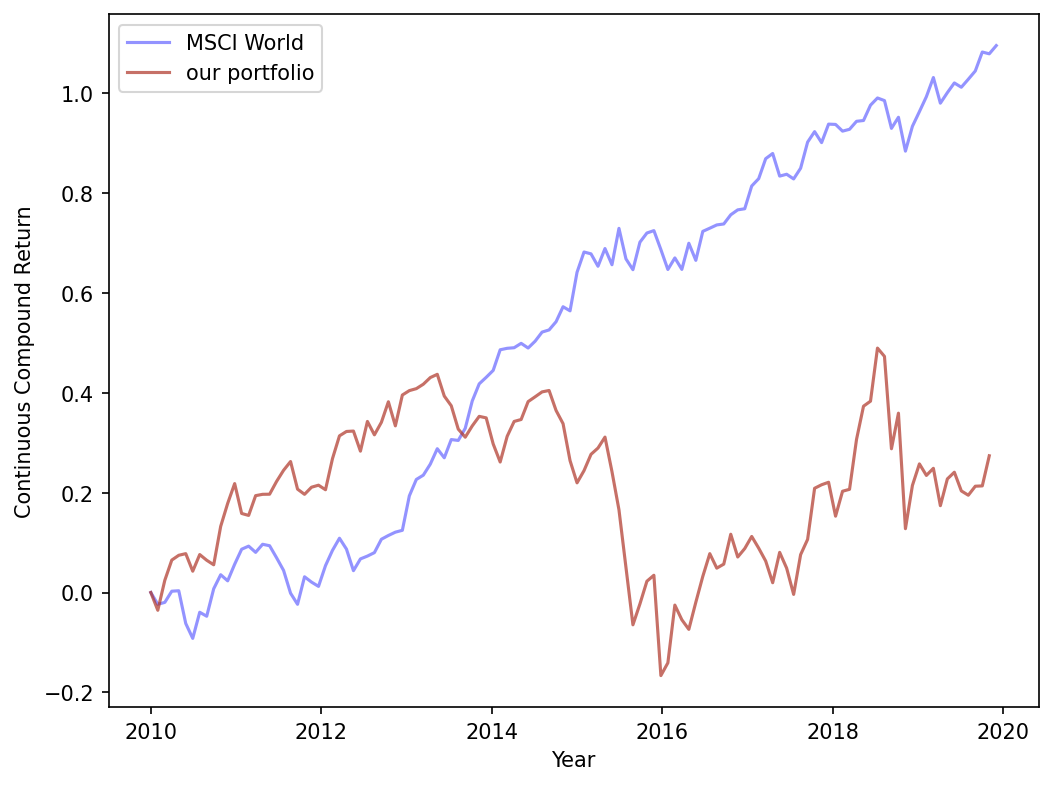

In [22]:
fig = figure(figsize=(8, 6), dpi=150)

x = np.arange(2010, 2020, 10/(len(both_returns['market returns'])+1))[:-1]
y_market = [0]+list(np.cumsum(both_returns['market returns']))
y_portfolio = [0]+list(np.cumsum(both_returns['portfolio returns']))


plt.plot(x, y_market, linewidth=1.5, c=cmap[0], label='MSCI World')
plt.plot(x, y_portfolio, linewidth=1.5, c=cmap[2], label="our portfolio")

plt.xlabel('Year')
plt.ylabel('Continuous Compound Return')
plt.legend()


# Treynor-Mazuy

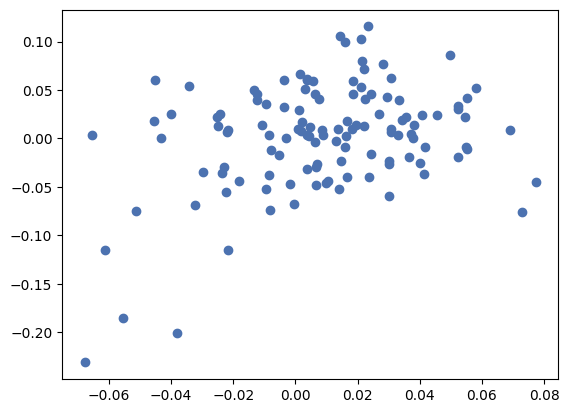

In [23]:
both_returns = both_returns.dropna()
plt.scatter(both_returns['market returns'], both_returns['portfolio returns'])
#plt.plot(both_returns['market returns'])

Parabola coeff Treynor-Mazuy: -4.103617672450792


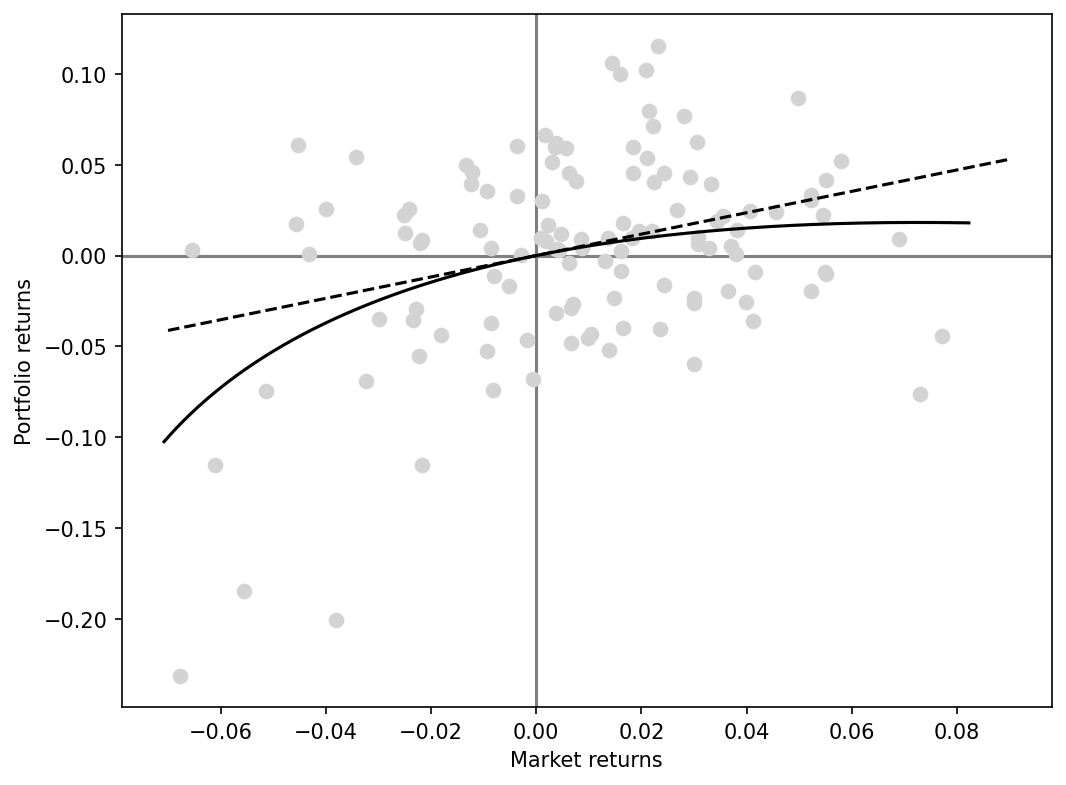

30.50781652626744

In [28]:
import numpy as np
from scipy.optimize import curve_fit
from math import degrees, atan2


# Rotate points
def rotate(x, y, degrees):
    pts = np.array([pair for pair in zip(x, y)])
    radians = np.radians(degrees)
    rot_mat = np.array([[np.cos(radians),-np.sin(radians)],
                        [np.sin(radians), np.cos(radians)]])
    einsum = np.einsum('ji, mni -> jmn', rot_mat, [pts])
    pts_rotated = np.squeeze(einsum).T
    return pts_rotated


fig = figure(figsize=(8, 6), dpi=150)

#model1 = np.poly1d(np.polyfit(both_returns['market returns'], both_returns['portfolio returns'], 1))
#model2 = np.poly1d(np.polyfit(both_returns['market returns'], both_returns['portfolio returns'], 2))

#line
def model_f(x, m):
    return m*x

#parabola
def parabola(x, a):
    return a* x**2

popt, pcov = curve_fit(model_f, both_returns['market returns'], both_returns['portfolio returns'])#opt values and cov matrix
m_opt = popt[0] # get optimal values
#create scatterplot
plt.scatter(both_returns['market returns'], both_returns['portfolio returns'], linewidth=1.5, c='lightgrey')

x_line = np.linspace(-0.07, 0.09, num=500)
y_line = model_f(x_line, m_opt)
plt.plot(x,  y_line, linewidth=1.5 , color='black', ls="--")

angle = degrees(atan2(y_line[-1], x[-1]))

pts_rotated = rotate(both_returns['market returns'], both_returns['portfolio returns'], -angle)

popt, pcov = curve_fit(parabola, pts_rotated[:,0], pts_rotated[:,1])
a_opt = popt[0] # get optimal values
x_curve = np.linspace(-0.113, 0.08, num=500)
y_curve = parabola(x_curve, a_opt)


curve_rotated = rotate(x_curve, y_curve, angle)

print("Parabola coeff Treynor-Mazuy: {}".format(a_opt))

plt.plot(curve_rotated[:,0], curve_rotated[:,1], c='black')

plt.axvline(0, color='grey', zorder=-1)
plt.axhline(0, color='grey', zorder=-1)
plt.xlabel("Market returns")
plt.ylabel("Portfolio returns")


plt.show()

In [ ]:
#The results might change between runs because the points are computed at random

In [ ]:
for i in range(len(f_r)):
    print("Highest return portfolio, Sliding Window ", i +1)
    print(frontiers_portfolios[i][np.argmax(f_r[i])])
    print("__________________________________________")

In [ ]:
# Less risky portfolio
for i in range(len(f_r)):
    print("Lowest risk portfolio, Sliding Window ", i +1)
    print(frontiers_portfolios[i][np.argmin(f_v[i])])
    print("__________________________________________")

In [ ]:
#Highest sharpe ratio

for i in range(11):
    SharpeR = np.array(f_r[i]) / np.array(f_v[i])
    print("Highest Sharpe-ratio portfolio, Sliding Window ", i +1)
    print(frontiers_portfolios[i][np.argmax(SharpeR)])
    print("__________________________________________")

# Let's try to replicate the previous efficient frontiers with a library

In [ ]:
!pip install PyPortfolioOpt

In [ ]:
from pypfopt import EfficientFrontier
from pypfopt import plotting

# Create a figure and a 3x3 grid of subplots
fig, axs = plt.subplots(11, figsize=(6, 50))

# Loop through the subplots and plot something on each of them
for i in range(11):
    ef = EfficientFrontier(sliding_windows_data[str(i+1)+'_yearly_mean'], sliding_windows_data[str(i+1)+'_yearly_cov'], weight_bounds=(0, 1))
    plotting.plot_efficient_frontier(ef, ax=axs[i], show_assets=True)
    axs[i].set_xlabel('Standard Deviation (Risk)')
    axs[i].set_ylabel('Expected Return')
    
count = 0
for ax in axs.flat:
    count +=1
    ax.set_title("SLIDING WINDOW " + str(count))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot
plt.show()

### The results are the same, we can use the library to use compute the efficient frontier with risk free rate 1

## Efficient frontier risk free rate

In [ ]:
Rf = 0.01


fig, axs = plt.subplots(11, figsize=(6, 50))

# Loop through the subplots and plot something on each of them
for i in range(11):
    ef = EfficientFrontier(sliding_windows_data[str(i+1)+'_yearly_mean'], sliding_windows_data[str(i+1)+'_yearly_cov'], weight_bounds=(0, 1))
    plotting.plot_efficient_frontier(ef, ax=axs[i], show_assets=True)
    #need to create another instance
    ef2 = EfficientFrontier(sliding_windows_data[str(i+1)+'_yearly_mean'], sliding_windows_data[str(i+1)+'_yearly_cov'], weight_bounds=(0, 1))
    Best_portfolio = ef2.max_sharpe(risk_free_rate=0) #best portfolio weights
    stats = ef2.portfolio_performance(verbose=False, risk_free_rate=0)
    Rp = stats[0]
    sigma = stats[1]
    
    xs = np.linspace(0, 2)
    sigma_c = xs * sigma # slide 22 ch05
    Rc = Rf + (Rp - Rf)/sigma * sigma_c
    
    
    opt = axs[i].scatter(sigma, Rp, marker = '*', c = 'red', s=100, label = 'optimal portfolio')#best performance portfolio
    line1, = axs[i].plot(sigma_c, Rc, "-", color="k", linewidth=0.8, label = 'lending and borrowing')
    axs[i].set_xlabel('Standard Deviation (Risk)')
    axs[i].set_ylabel('Expected Return')
    axs[i].legend()
    
count = 0
for ax in axs.flat:
    count +=1
    ax.set_title("SLIDING WINDOW " + str(count))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot
plt.show()


### 5 real bonds data

In [1]:
#10Y coupon = 4.125, price at 14:42, 10/01/23: 104.3281 maturity = 15 NOV 2032
#30Y coupon = 4, 105.1406, 10/01/23 at 14:40 maturity = 15 NOV 2052
#5Y coupon = 3.875, price at 10/01/23, 100.6641, 14:40 maturity = 31 DEC 2027
#3Y coupon = 4, , price 99.9766 14:40 maturity = 15 DEC 2025
#2Y coupon = 4.25, price 99.9727 at 10/01/23, 14:39 maturity 31 DEC 2024
#data imported from investing.com from 01/01/2022 to 10/01/2023 (in order to get more data even if it's outside set date)

In [2]:
prices = [99.9727, 99.9766, 100.6641, 104.3281, 105.1406 ]
coupons = [4, 4.25, 3.875, 4.125, 4]
periods = [2,3,5,10,30] #years to maturity
YTM = []
face_value = 100

### for YTM we can compute the yield with the newton method specifying the correct formula for each bond as done below

In [3]:
from scipy.optimize import newton
C_t = lambda coupon: (100 * coupon/100)/2
lambda_function = lambda y, p, coupon, price: sum([(C_t(coupon)/((1+y/2)**a)) for a in list(range(1,p))]) + (face_value + C_t(coupon))/((1+y/2)**p) - price

In [4]:
for period, coupon, price in zip(periods, coupons, prices):
    US_lambda = lambda y: lambda_function(y, period*2, coupon, price)
    r = round(newton(US_lambda, 0.1)*100,2)
    print(f"YTM US{period}Y: " + str(r))
    YTM.append(r)

YTM US2Y: 4.01
YTM US3Y: 4.26
YTM US5Y: 3.73
YTM US10Y: 3.61
YTM US30Y: 3.71


### We can automitize the previous procedure by using some approximation formula (in this way we can automize the yield to maturity based on period and so on ...) that return really similar values:

In [5]:
def YTM_func(price, face, coupon, periods):
    def bond_price_calc(YTM):
        return ((coupon*((1-(1+YTM)**-periods))/YTM)+((face)/(1+YTM)**periods))-price
    return bond_price_calc

In [6]:
for i in range(5):
    r = round(newton(YTM_func(price=prices[i],face=100,coupon=coupons[i],periods=periods[i]), 0.01)*100, 2)
    print("YTM (APPROXIMATION) BOND " +str(i) + ": " + str(r))

YTM (APPROXIMATION) BOND 0: 4.01
YTM (APPROXIMATION) BOND 1: 4.26
YTM (APPROXIMATION) BOND 2: 3.73
YTM (APPROXIMATION) BOND 3: 3.6
YTM (APPROXIMATION) BOND 4: 3.71


In [7]:
### tutorial youtube
###https://www.investopedia.com/terms/d/duration.asp

import numpy as np
import pandas as pd
import bond_pricing

def Duration(rate, coupon_rate, frequency, face_value, settlement_date, maturity_date, change_in_yield):
    
    try:
        settlement_date = pd.to_datetime(settlement_date, format="%d/%m/%Y")
    except:
        settlement_date = pd.to_datetime(settlement_date, format="%d-%m-%Y")
        
    try:
        maturity_date = pd.to_datetime(maturity_date, format="%d/%m/%Y")
    except:
        maturity_date = pd.to_datetime(maturity_date, format="%d-%m-%Y")
    
    data = pd.DataFrame()
    rate = rate/100
    coupon_rate = coupon_rate/100
    
    #duration
    n = pd.to_numeric(((pd.to_datetime(maturity_date) - pd.to_datetime(settlement_date))/365).days)
    total_payment = n*frequency #(years times payment freq)
    coupon_payment = coupon_rate/frequency * face_value
    payment = [coupon_payment] *(total_payment-1) + [coupon_payment + face_value] ## all payments [coup, coup, ... coup+par]
    data['period'] = pd.DataFrame(np.arange(1,total_payment + 1)) # number of payments (arange skip last value)
    data['payment'] = pd.DataFrame(payment)
    data['dcoupon'] = data['payment'] / ((1 + rate/frequency)**data['period'])
    data['pv'] = data['dcoupon'] / frequency * data['period'] / data['dcoupon'].sum()#duration formula per period
    duration = data['pv'].sum() #sum to obtain duration
    m_duration = duration / (1+ (rate/frequency))
    
    
    #convexity
    #factor = 1/(data['dcoupon'].sum() * (1+rate/frequency)**2)
    
    #as in the book:
    data['cf'] = (data['payment']*(data['period']**2 + data['period'])) / (1+rate/frequency)**data['period']
    convexity = 0.5* data['cf'].sum() / data['dcoupon'].sum()
    
    #price change = duration + conv  effcts
    price_change = (-duration * change_in_yield ) + ( convexity * (change_in_yield)**2 )
    
    bond_price = data['dcoupon'].sum()#bond_pricing.simple_bonds.bond_price(settle=settlement_date, cpn=coupon_rate, mat=maturity_date, yld=rate, freq=frequency, face=face_value)
    
    corrected_price = (bond_price* price_change) + bond_price  
    
    return duration, m_duration, convexity, price_change, bond_price, corrected_price, data
    
    
    
    
    
       

C:\Users\fiori\AppData\Roaming\Python\Python310\site-packages\bond_pricing\simple_bonds.py:528: UserWarning: Module isda_daycounters is not installed.
Only 'simple' daycount (basically ACT/365) is available.
To use other daycounts, install isda_daycounters from
https://github.com/miradulo/isda_daycounters
  warn("Module isda_daycounters is not installed.\n"


# Book example

In [8]:
Duration(10, 0, 1,1000, "01/01/2022", "01/01/2027", 0.02)
#bond_pricing.simple_bonds.bond_duration(settle="01/01/2022", mat="01/01/2032", cpn=5/100, yld=5/100, freq=1)

(5.0,
 4.545454545454545,
 15.000000000000002,
 -0.094,
 620.9213230591549,
 562.5547186915944,
    period  payment     dcoupon   pv            cf
 0       1      0.0    0.000000  0.0      0.000000
 1       2      0.0    0.000000  0.0      0.000000
 2       3      0.0    0.000000  0.0      0.000000
 3       4      0.0    0.000000  0.0      0.000000
 4       5   1000.0  620.921323  5.0  18627.639692)

In [9]:
#US2Y

BOND (US2Y) DURATION = 1.9419352947537565
BOND (US2Y) CONVEXITY = 9.613539354385738


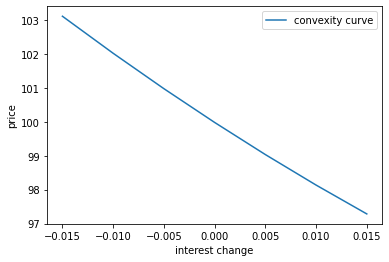

In [10]:
import matplotlib.pyplot as plt
face_value = 100

results = Duration(YTM[0], coupons[0],2, face_value, "31-12-2022", "31-12-2024", 0)
duration = results[0]
convexity = results[2]
print("BOND (US2Y) DURATION = " + str(duration))
print("BOND (US2Y) CONVEXITY = " + str(convexity))

#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[0], coupons[0],2, face_value, "31-12-2022", "31-12-2024", i)[5])
plt.plot(interest_rate_shift, l, label="convexity curve")

plt.xlabel("interest change")
plt.ylabel('price')
plt.legend()

BOND (US3Y) DURATION = 2.848178663414176
BOND (US3Y) CONVEXITY = 19.58793950771733


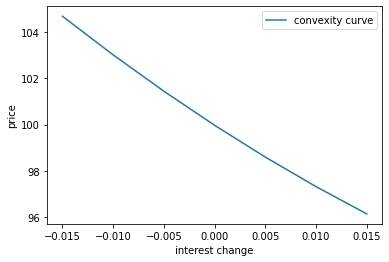

In [11]:
#US3Y
face_value = 100

results = Duration(YTM[1], coupons[1], 2, face_value, "15-12-2022", "15-12-2025", 0)
duration = results[0]
convexity = results[2]
print("BOND (US3Y) DURATION = " + str(duration))
print("BOND (US3Y) CONVEXITY = " + str(convexity))

#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[1], coupons[1], 2, face_value,  "15-12-2022", "15-12-2025", i)[5])
plt.plot(interest_rate_shift, l, label="convexity curve")

plt.xlabel("interest change")
plt.ylabel('price')
plt.legend()

BOND (US5Y) DURATION = 4.594939570215166
BOND (US5Y) CONVEXITY = 49.09527153708739


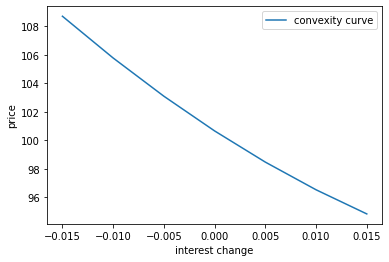

In [12]:
#US5Y
face_value = 100

results = Duration(YTM[2], coupons[2], 2, face_value, "31-12-2022", "31-12-2027", 0)
duration = results[0]
convexity = results[2]
print("BOND (US5Y) DURATION = " + str(duration))
print("BOND (US5Y) CONVEXITY = " + str(convexity))

#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[2], coupons[2], 2, face_value,  "31-12-2022", "31-12-2027", i)[5])
plt.plot(interest_rate_shift, l, label="convexity curve")

plt.xlabel("interest change")
plt.ylabel('price')
plt.legend()

BOND (US10Y) DURATION = 8.336878545213114
BOND (US10Y) CONVEXITY = 164.0424622320534


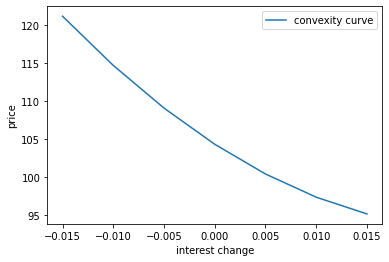

In [13]:
#US10Y
face_value = 100

results = Duration(YTM[3], coupons[3], 2, face_value, "15-11-2022", "15-11-2032", 0)
duration = results[0]
convexity = results[2]
print("BOND (US10Y) DURATION = " + str(duration))
print("BOND (US10Y) CONVEXITY = " + str(convexity))

#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[3], coupons[3], 2, face_value,  "15-11-2022", "15-11-2032", i)[5])
plt.plot(interest_rate_shift, l, label="convexity curve")

plt.xlabel("interest change")
plt.ylabel('price')
plt.legend()

BOND (US30Y) DURATION = 18.053555949521105
BOND (US30Y) CONVEXITY = 898.1540170872494


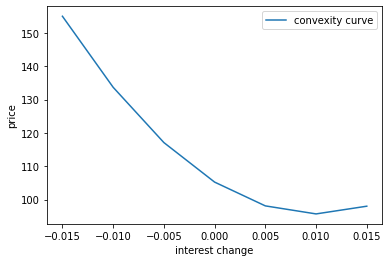

In [14]:
#US30Y
face_value = 100

results = Duration(YTM[4], coupons[4], 2, face_value, "15-11-2022", "15-11-2052", 0)
duration = results[0]
convexity = results[2]
print("BOND (US30Y) DURATION = " + str(duration))
print("BOND (US30Y) CONVEXITY = " + str(convexity))

#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[4], coupons[4], 2, face_value,  "15-11-2022", "15-11-2052", i)[5])
plt.plot(interest_rate_shift, l, label="convexity curve")

plt.xlabel("interest change")
plt.ylabel('price')
plt.legend()

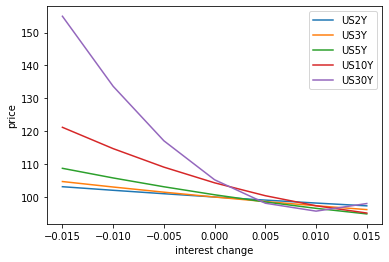

In [15]:
import matplotlib.pyplot as plt
face_value = 100

#print how price will change with some intresets rates changes
#US2Y
interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[0], coupons[0],2, face_value, "31-12-2022", "31-12-2024", i)[5])
plt.plot(interest_rate_shift, l, label="US2Y")

#print how price will change with some intresets rates changes

#US3Y
interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[1], coupons[1], 2, face_value,  "15-12-2022", "15-12-2025", i)[5])
plt.plot(interest_rate_shift, l, label="US3Y")

#US5Y
#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[2], coupons[2], 2, face_value,  "31-12-2022", "31-12-2027", i)[5])
plt.plot(interest_rate_shift, l, label="US5Y")

#US10Y


#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[3], coupons[3], 2, face_value,  "15-11-2022", "15-11-2032", i)[5])
plt.plot(interest_rate_shift, l, label="US10Y")

#US30Y

#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[4], coupons[4], 2, face_value,  "15-11-2022", "15-11-2052", i)[5])
plt.plot(interest_rate_shift, l, label="US30Y")

plt.xlabel("interest change")
plt.ylabel('price')
plt.legend()

## Bonds portfolio

In [16]:
#conversion
from forex_python.converter import CurrencyRates

c = CurrencyRates()

USD = 100000 * c.get_rate('EUR', 'USD')

In [17]:
USD

108120.0

In [18]:
prices     #market prices

[99.9727, 99.9766, 100.6641, 104.3281, 105.1406]

In [19]:
bonds_portfolio = []
for p in prices:
    num_bonds = int(USD/ p)
    bonds_portfolio.append(num_bonds)
bonds_portfolio

[1081, 1081, 1074, 1036, 1028]

In [20]:
spent = np.array(bonds_portfolio) * np.array(prices)# how much was spent for each bond
#compute weights:
weights = spent/ spent.sum()
weights

array([0.19997245, 0.19998025, 0.20005156, 0.19999729, 0.19999845])

In [21]:
#Duration of portfolio:

durations = []
durations.append(round(Duration(YTM[0], coupons[0], 2, face_value, "31-12-2022", "31-12-2024", 0)[0],2))
durations.append(round(Duration(YTM[1], coupons[1], 2, face_value,  "15-12-2022", "15-12-2025", 0)[0],2))
durations.append(round(Duration(YTM[2], coupons[2], 2, face_value,  "31-12-2022", "31-12-2027", 0)[0],2))
durations.append(round(Duration(YTM[3], coupons[3], 2, face_value,  "15-11-2022", "15-11-2032", 0)[0],2))
durations.append(round(Duration(YTM[4], coupons[4], 2, face_value,  "15-11-2022", "15-11-2052", 0)[0],2))
durations

[1.94, 2.85, 4.59, 8.34, 18.05]

In [22]:
#Convexity of portfolio:

convs = []
convs.append(round(Duration(YTM[0], coupons[0], 2, face_value, "31-12-2022", "31-12-2024", 0)[2],2))
convs.append(round(Duration(YTM[1], coupons[1], 2, face_value,  "15-12-2022", "15-12-2025", 0)[2],2))
convs.append(round(Duration(YTM[2], coupons[2], 2, face_value,  "31-12-2022", "31-12-2027", 0)[2],2))
convs.append(round(Duration(YTM[3], coupons[3], 2, face_value,  "15-11-2022", "15-11-2032", 0)[2],2))
convs.append(round(Duration(YTM[4], coupons[4], 2, face_value,  "15-11-2022", "15-11-2052", 0)[2],2))
convs

[9.61, 19.59, 49.1, 164.04, 898.15]

In [31]:
p_dur = (weights * durations).sum()
print("Duration of portfolio: "+ str(p_dur))

Duration of portfolio: 7.15407627187643


In [32]:
p_conv = (weights * convs).sum()
print("Convexity of portfolio: "+ str(p_conv))

Convexity of portfolio: 228.09803896679784


### compute market value loss as yield increases

In [34]:
#change in price with 150 basis increase in yield:
new_prices = []
new_prices.append(round(Duration(YTM[0], coupons[0], 2, face_value, "31-12-2022", "31-12-2024", 0.015)[5],2))
new_prices.append(round(Duration(YTM[1], coupons[1], 2, face_value,  "15-12-2022", "15-12-2025", 0.015)[5],2))
new_prices.append(round(Duration(YTM[2], coupons[2], 2, face_value,  "31-12-2022", "31-12-2027", 0.015)[5],2))
new_prices.append(round(Duration(YTM[3], coupons[3], 2, face_value,  "15-11-2022", "15-11-2032", 0.015)[5],2))
new_prices.append(round(Duration(YTM[4], coupons[4], 2, face_value,  "15-11-2022", "15-11-2052", 0.015)[5],2))
new_prices # new prices after change in yield

[97.28, 96.14, 94.83, 95.1, 97.99]

In [35]:
#price_c = (np.array(bonds_portfolio) * np.array(new_prices)).sum()

In [36]:
#ini_price = (np.array(bonds_portfolio) * np.array(prices)).sum()

In [40]:
#loss = (price_c - ini_price) / ini_price
loss = (-p_dur * 0.015) + (0.5* p_conv * 0.015**2)
print("the portfolio market value had decreased by: "+ str(round(loss, 4 ) * 100) + "%") 

the portfolio market value had decreased by: -8.17%


## Computing dirty prices

In [ ]:
def dirty_price(PV, payments_per_period, t, coupon, face_value): #t=days since last payment day
    coupon = coupon/100
    interest =  coupon/payments_per_period * t/365 *face_value
    return PV + interest

In [ ]:
#prices #market prices (present value)
def compute_dirty_prices(num_payments_period, init_date, end_date,current_date, PV, coupon, face_value):
    #num_payments_period = 2
    init_date = pd.to_datetime(init_date, format="%d/%m/%Y") #day after the market prices where taken
    end_date = pd.to_datetime(end_date, format="%d/%m/%Y")
    current_date = pd.to_datetime(current_date, format="%d/%m/%Y")
    
    days_to_m = pd.to_numeric(((pd.to_datetime(end_date) - pd.to_datetime(init_date))).days) #days until maturity
    time_passed = days_to_m - pd.to_numeric(((pd.to_datetime(end_date) - pd.to_datetime(current_date))).days)
    
    years = days_to_m/365
    days_per_period = days_to_m / (years*num_payments_period)

    periods = years*num_payments_period
    dirty_prices = []
    total_days = 0
    for period in range(int(periods)):
        loop = int(days_per_period)
        if period % num_payments_period == 1: #add 1 day in odd periods, IT'S ALWAYS 2 IN MY CASE
            loop += 1
        for days_passed in range(loop):#I need to start from the 10/01
            if total_days > time_passed:
                dirty_prices.append(dirty_price(PV, num_payments_period, days_passed, coupon, face_value))
            total_days+=1
    
    dirty_prices.append(dirty_price(PV, num_payments_period, 0, coupon, face_value))#last value to complete the plot    
    return dirty_prices, time_passed, total_days

In [ ]:
d_prices, time_passed, tot_days = compute_dirty_prices(2, "31/12/2022","31/12/2024","10/01/2023", prices[0], coupons[0], 100)
#plt.plot(np.array(range(len(d_prices)))+10, d_prices)
#plt.plot(np.array(range(10 , 730)), d_prices) #same

fig, ax = plt.subplots(1,1)
ticks =[x for x in range(len(d_prices)) if x%100 == 0]
ticks.append(time_passed)
ticks.remove(0)
p=ax.plot(np.array(range(len(d_prices)))+10, d_prices)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.set_title("Dirty prices US2Y")
ax.set_xlabel('Days')
ax.set_ylabel('Price')
#ax.set_xlim([10, 730])

In [ ]:
current_date = "10/01/2023"
start_dates = [ "31/12/2022","15/12/2022", "31/12/2022", "15/11/2022","15/11/2022" ]
end_dates = [ "31/12/2024","15/12/2025", "31/12/2027", "15/11/2032","15/11/2052" ]

bonds_d_p = []

fig, ax = plt.subplots(5, figsize=(16, 25))

for i in range(5):
    d_prices, time_passed, tot_days = compute_dirty_prices(2, start_dates[i],end_dates[i],current_date, prices[i],  coupons[i], face_value)
    bonds_d_p.append(d_prices)
    
    ticks =[x for x in range(len(d_prices)) if x%100 == 0]
    ticks.append(time_passed)
    ticks.remove(0)
    p=ax[i].plot(np.array(range(len(d_prices)))+10, d_prices)
    #ax[i].set_xticks(ticks)
    #ax[i].set_xticklabels(ticks)
    ax[i].set_title("Dirty prices Bond " + str(i+1))
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Price')
    #ax.set_xlim([10, 730])

# Apply dirty prices to portfolio

In [ ]:
#plot the market value of the portfolio against days, every time a bond is matured remove it ofc.

In [ ]:
#IF I BUY THE BONDS THE 10/01/2023 I WIL BUY THEM AT THE DIRTY PRICE
initial_prices = [bonds_d_p[0][0], bonds_d_p[1][0], bonds_d_p[2][0], bonds_d_p[3][0], bonds_d_p[4][0]]

In [ ]:
bonds_portfolio = []
for p in initial_prices:
    num_bonds = int(USD/ p)
    bonds_portfolio.append(num_bonds)
bonds_portfolio #less than before, the market price didn't consider the dirty price bcs it's a treasury bond

In [ ]:
spent = np.array(bonds_portfolio) * np.array(initial_prices)# how much was spent for each bond
#compute weights:
weights = spent/ spent.sum()
weights

In [ ]:
#making all array of same length
for i in range(len(bonds_d_p)):
    N = len(bonds_d_p[4]) - len(bonds_d_p[i])
    bonds_d_p[i] = np.pad(bonds_d_p[i], (0, N), 'constant')

In [ ]:
sums = np.zeros(len(bonds_d_p[4]))
for x in bonds_d_p:
    sums += x
    
sums*= 100000

In [ ]:
plt.plot(sums)
plt.title("Portfolio value with dirty pricing")
plt.xlabel("days")
plt.ylabel("value")
#note that the segmented lines are the dirty pricing effects and the shape similar to a step function it's because the 
#bonds will mature in that date and thus the portfolio will decrease in value since we will receive the money for that bond